In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gensim, nltk, warnings
import json
import re
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from tqdm.autonotebook import tqdm
from functools import partial
from nltk.probability import FreqDist
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
stop = stopwords.words('english')
all_stopwords2 = {'.',',',':',';','%'}
os.listdir('/kaggle/input/coleridgeinitiative-show-us-the-data/')
warnings.filterwarnings(action = 'ignore')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
train_df = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/train.csv')
sample_sub = pd.read_csv('../input/coleridgeinitiative-show-us-the-data/sample_submission.csv')
train_files_path = '../input/coleridgeinitiative-show-us-the-data/train'
test_files_path = '../input/coleridgeinitiative-show-us-the-data/test'

In [4]:
def Concatenate(filename, files_path=train_files_path, output='text'):
    json_path = os.path.join(train_files_path, (filename + '.json'))
    headings = []
    contents = []
    combined = []
    with open(json_path, 'r') as f:
        json_decode = json.load(f)
        for data in json_decode:
            headings.append(data.get('section_title'))
            contents.append(data.get('text'))
            combined.append(data.get('section_title'))
            combined.append(data.get('text'))

    all_headings = ' '.join(headings)
    all_contents = ' '.join(contents)
    all_data = '. '.join(combined)

    if output == 'text':
        return all_contents
    elif output == 'head':
        return all_headings
    else:
        return all_data
tqdm.pandas()
train_df['text'] = train_df['Id'].progress_apply(Concatenate)
tqdm.pandas()
sample_sub['text'] = sample_sub['Id'].progress_apply(partial(Concatenate, files_path=test_files_path))

  0%|          | 0/19661 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [5]:
def clean(text):
    text = text.replace("\n", " ")
    text = re.sub('[0-9]+.\t', '', str(text))
    text = re.sub('\n ', '', str(text))
    text = re.sub('\n', ' ', str(text))
    text = re.sub("'s", '', str(text))
    text = re.sub("-", ' ', str(text))
    text = re.sub("— ", '', str(text))
    text = re.sub('\"', '', str(text))
    text = re.sub("Mr\.", 'Mr', str(text))
    text = re.sub("Mrs\.", 'Mrs', str(text))
    text = re.sub("[\(\[].*?[\)\]]", "", str(text))
    return text
tqdm.pandas()
train_df['text'] = train_df['text'].progress_apply(clean)
sample_sub['text'] = sample_sub['text'].progress_apply(clean)

  0%|          | 0/19661 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [7]:
train_df['text'].head(50).progress_apply(lambda x: [item for item in x if item not in stop])

  0%|          | 0/50 [00:00<?, ?it/s]

0     [P, r, c, p, n, g,  , n,  , r, e, g, u, l, r, ...
1     [M, u, l,  , k,  , l, e, r, n, n, g,  ,  ,  , ...
2     [H, n, g,  , K, n, g,  , n, e, w,  , c, e, c, ...
3     [©,  , O, p, e, n, S, r, e, e, M, p,  ,  , c, ...
4     [N, A, T, I, O, N, A, L,  , S, C, I, E, N, C, ...
5     [A,  , f, u, n, e, n, l,  , p, r, b, l, e,  , ...
6     [S, n, c, e,  , h, e,  , p, l, e,  , z, e,  , ...
7     [c, e, n, c, e,  , n,  , e, n, g, n, e, e, r, ...
8     [I,  ,  , h, e,  , P, l, c,  , f,  , C, r, n, ...
9     [T,  , g, n,  , f, u, r, h, e, r,  , k, n, w, ...
10    [P, n,  , n,  , n, e, n,  ,  , f, r,  , h, e, ...
11    [H, g, h,  , e, n, n, l,  , p, e, r, n,  , c, ...
12    [u, u, l, l,  , p, e, r, f, r, e,  , u, n, e, ...
13    [P, e, r, c, e, n, g, e,  , f,  , F, r, e, g, ...
14    [A, b, r, c, .,  , L, r, g, e,  , c, l, e,  , ...
15    [g, e, n, e, r,  , g, p,  , n,  , c, l, l, e, ...
16    [A, p, p, e, n, x,  , A, .,  , S, u, r, v, e, ...
17    [A, B, S, T, R, A, C, T,  , A, l, z, h, e,

In [8]:
L =[]
for k in range (19661):
    L.append(k)
train_df['Model_Num'] = L

In [9]:
def tokenize(text):
    data = []
    for i in sent_tokenize(text): 
        for j in word_tokenize(i): 
            data.append(j.lower())
    return data
tqdm.pandas()
train_df['tokenized_text'] = train_df['text'].head(50).progress_apply(tokenize)
tqdm.pandas()
train_df['tokenized_label'] = train_df['cleaned_label'].progress_apply(tokenize)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/19661 [00:00<?, ?it/s]

In [10]:
train_df.head(50)

,Id,pub_title,dataset_title,dataset_label,cleaned_label,text,Model_Num,tokenized_text,tokenized_label
0,54693c94-2ed7-4558-b07b-5c43f71d3743,Examining the Impact of Integrating Physical A...,Early Childhood Longitudinal Study,Early Childhood Longitudinal Study,early childhood longitudinal study,Participating in regular physical activity is ...,0,"[participating, in, regular, physical, activit...","[early, childhood, longitudinal, study]"
1,4bd685b3-02d3-45dc-9890-d7fe262302c2,Multi-Task Learning with Incomplete Data for H...,Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,adni,Multi task learning is a type of transfer lear...,1,"[multi, task, learning, is, a, type, of, trans...",[adni]
2,e2f88290-5f78-45fa-a1b6-fa3e07a6b977,Developing students' critical thinking skills ...,Trends in International Mathematics and Scienc...,Trends in International Mathematics and Scienc...,trends in international mathematics and scienc...,Hong Kong new academic structure has been a to...,2,"[hong, kong, new, academic, structure, has, be...","[trends, in, international, mathematics, and, ..."
3,c8deeb27-9a8f-45fa-9b6b-69cff8554d12,Choptank ecological assessment: digital atlas...,Coastal Change Analysis Program,Coastal Change Analysis Program,coastal change analysis program,"© OpenStreetMap contributors, CC BY SA, Sourc...",3,"[©, openstreetmap, contributors, ,, cc, by, sa...","[coastal, change, analysis, program]"
4,430aa11c-0283-411b-8edc-08f5df3db258,Science and Engineering Indicators 2008,Survey of Science and Engineering Research Fac...,Survey of Science and Engineering Research Fac...,survey of science and engineering research fac...,NATIONAL SCIENCE FOUNDATION National Science...,4,"[national, science, foundation, national, scie...","[survey, of, science, and, engineering, resear..."
5,91ec90c1-9503-4433-a5ea-14bef239bdcc,Regularized Bagged Canonical Component Analysi...,Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,adni,A fundamental problem of supervised learning a...,5,"[a, fundamental, problem, of, supervised, lear...",[adni]
6,f74f94aa-84aa-451a-96d6-fcc63827b4d3,Genetic imaging consortium for addiction medic...,Alzheimer's Disease Neuroimaging Initiative (A...,ADNI,adni,Since the sample size of a typical neuroimagin...,6,"[since, the, sample, size, of, a, typical, neu...",[adni]
7,6cc875c4-594f-4366-a0b4-06fe4b480ac8,Science and engineering degrees: 1966-2004,Survey of Earned Doctorates,Survey of Earned Doctorates,survey of earned doctorates,science and engineering 4 fields other than sc...,7,"[science, and, engineering, 4, fields, other, ...","[survey, of, earned, doctorates]"
8,02361701-98bf-44c8-869c-9a4f69a82d40,Dairy Farm Cost Efficiency,Agricultural Resource Management Survey,Agricultural Resource Management Survey,agricultural resource management survey,It is the Policy of Cornell University activel...,8,"[it, is, the, policy, of, cornell, university,...","[agricultural, resource, management, survey]"
9,cee26143-cc83-4aeb-b861-e8b928c26938,The down syndrome biomarker initiative (DSBI) ...,Alzheimer's Disease Neuroimaging Initiative (A...,Alzheimer's Disease Neuroimaging Initiative (A...,alzheimer s disease neuroimaging initiative adni,To gain further knowledge on the preclinical p...,9,"[to, gain, further, knowledge, on, the, precli...","[alzheimer, s, disease, neuroimaging, initiati..."


In [11]:
N = 25 #Number of most similar words
Similar_words = []
def WordToVec(Tokenized_text, ModelNum, Tokenized_label):
    for x in tqdm(ModelNum):
        model_text = Word2Vec(Tokenized_text.loc[[x]], min_count = 1, window = 5)
        model_label = Word2Vec(Tokenized_label.loc[[x]], min_count = 1, window = 5)
        Arr = np.zeros((100,))
        for words in Tokenized_label.loc[[x]]:
            for word in words:
                x = model_label.wv[word]
                Arr = np.add(Arr, x)
        Similar = model_text.wv.similar_by_vector(Arr, topn=N, restrict_vocab=None)
        for a in Similar:
            Similar_words.append(a[0])
WordToVec(train_df['tokenized_text'].head(50), train_df['Model_Num'].head(50), train_df['tokenized_label'].head(50))

  0%|          | 0/50 [00:00<?, ?it/s]

In [12]:
Similar_words = [word for word in Similar_words if not word in stopwords.words()]
Similar_words= [word for word in Similar_words if not word in all_stopwords2]

In [13]:
# print(Similar_words)

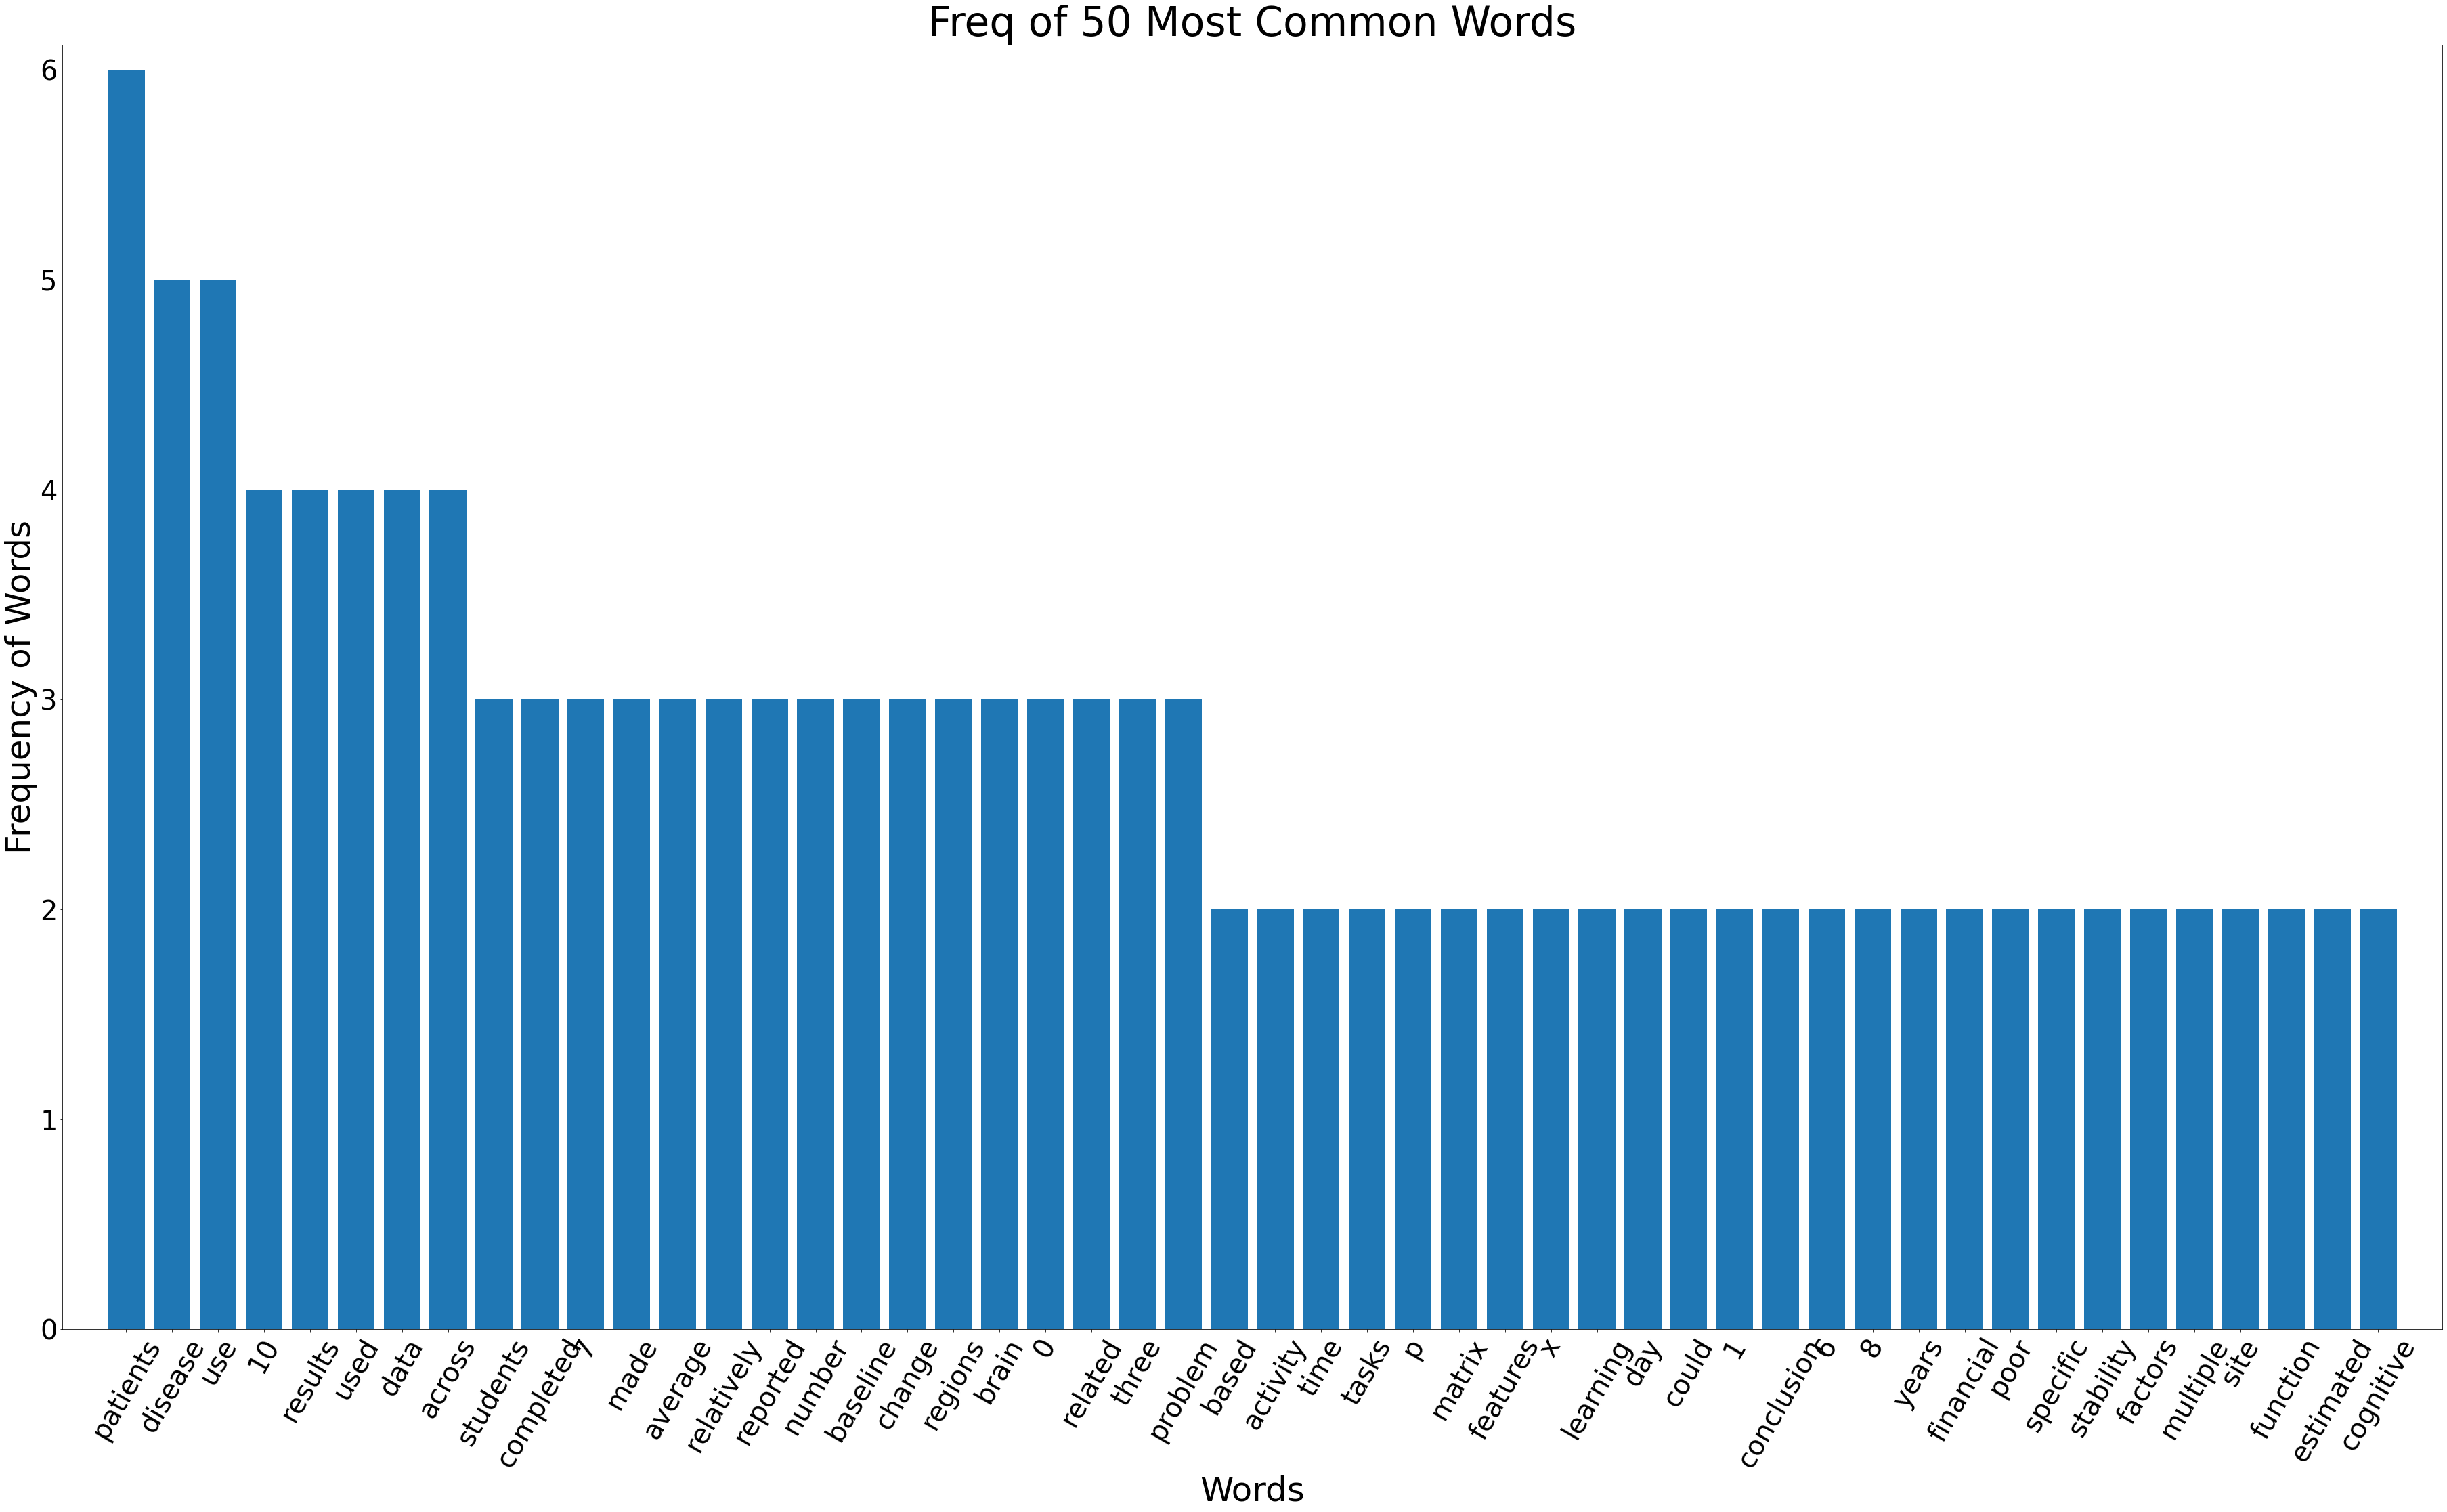

In [14]:
mostcommon = FreqDist(Similar_words).most_common(50)
x, y = zip(*mostcommon)
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('Words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.tight_layout(pad=0)
plt.title('Freq of 50 Most Common Words', fontsize=60)
plt.show()

In [15]:
from collections import Counter
Counter = Counter(Similar_words)
most_occur = Counter.most_common(25)
keywords=[]
for k in most_occur:
    keywords.append(k[0])
print(keywords)

['patients', 'disease', 'use', '10', 'results', 'used', 'data', 'across', 'students', 'completed', '7', 'made', 'average', 'relatively', 'reported', 'number', 'baseline', 'change', 'regions', 'brain', '0', 'related', 'three', 'problem', 'based']
